In [1]:
# make sure the notebook reloads the module each time we modify it
%load_ext autoreload
%autoreload 2

# make sure the displays are nice
%matplotlib inline
#figsize(12,8)

In [2]:
import solved_simple_regression as sr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")
import numpy as np
import numpy.linalg as npl

## Preparing data and utilities

Problem dimensions are (170,)


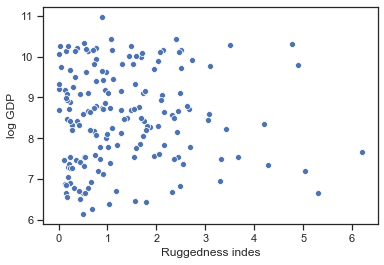

In [3]:
# I prepared a class that fetches data for you
PM = sr.PracticalMaterial()
X, y = PM.fetch_data()

# Let us plot data
sns.scatterplot(X, y)
print("Problem dimensions are", X.shape)
plt.ylabel("log GDP")
plt.xlabel("Ruggedness indes")
plt.show()

Say you work for a geographer. She wants to test the hypothesis that the log GDP increases with ruggedness. You reply that without knowledge about how $X$ and $y$ relate, and only 170 points, it seems reasonable to stick to a simple model, say linear regression. 

**Question:** Assuming you perform a linear regression of the log GDP onto the ruggedness index, how will you formalize the test that the geographer is asking for? What quantity do you want to report?

**Solution:** As Bayesians, we need a distribution over states and a loss function.
1. Linear regression and a choice of prior will give us a joint distribution $\pi$ over states $s=(X, \mathbf{y}, \theta)$, where $\theta=(\alpha,\beta,\sigma)$, $y_i=\alpha+\beta x_i+\epsilon_i$, and, for example, $\epsilon_i\sim\mathcal{N}(0,\sigma^2)$ i.i.d. 
2. The geographer's action can be modeled by a binary variable $a=1$ ("yes, it increases") or $a=0$ ("no, it doesn't") depending on whether GDP increases with ruggedness. She should tell us how much she would suffer if we answered yes/no and the state was $s$. We can then take
$$
L(a,s) = \ell_1 1_{\beta>0}1_{a=0} + \ell_2 1_{\beta\leq 0} 1_{a=1}.
$$
The Bayes action is then to say 'yes' (a=1) if and only if
$$ 
\pi(\beta>0\vert X,\mathbf{y}) > \frac{\ell_2}{\ell_1+\ell_2}.
$$


# Linear regression

**Question:** First write down your model (likelihood and prior), and find the MAP to get an idea what to expect.

**Solution:**
* Prior is $p(\theta) = p(\alpha,\beta,\log\sigma) = \mathcal{N}((0,0,0),I).$ Also try a Student, a Cauchy (in which case there's no variance).
* Likelihood is $p(\mathbf{y}\vert X, \theta) = \prod_{i=1}^n \mathcal{N}(y_i\vert \alpha+\beta x_i, \sigma^2)$.
* Posterior is proportional to 
$$ p(\theta\vert X,y) \propto p(\mathbf{y}\vert X, \theta)p(\theta).$$

In [4]:
theta_map, inverse_hessian = PM.find_map()
print("The MAP and the inverse Hessian are", theta_map, np.diag(inverse_hessian))

The MAP and the inverse Hessian are [8.51542449e+00 1.73798089e-03 2.24208963e+00] [0.5794775  0.23591653 0.20510252]


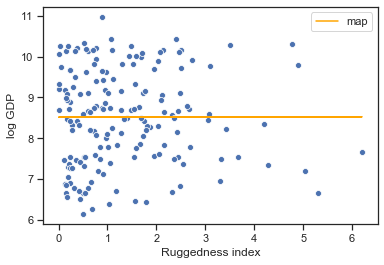

In [5]:
sns.scatterplot(X, y)
plt.ylabel("log GDP")
plt.xlabel("Ruggedness index")
plt.plot(X, theta_map[0] + theta_map[1]*X, label="map", color="orange")
plt.legend()
plt.show()

**Question:** we haven't performed Bayesian inference yet, but do you interpret the MAP as evidence for a yes or a no?

**Solution:** The MAP coefficient `theta_map[1]` doesn't seem to clearly favour either $\beta>0$ or $\beta<0$. To be more precise, we need to have an idea of how the mass is distributed around the MAP; hencce the next question.

**Question:** perform a Laplace approximation to the posterior, what would you then answer to the geographer? *Hint: we have already computed everything for the Laplace approximation, so answering this question should require no coding.

**Solution:** Under the Laplace approximation, $\pi(\cdot\vert X, \mathbf{y})$ is a Gaussian with mean `theta_map` and covariance matrix `inv_hess` (see Murphy, p255 and 256). So the marginal posterior on $\beta$ is simply a univariate Gaussian with mean `theta_map[1]` and variance `inv_hess[1,1]`. Now you can answer the geographer's question by checking how much mass this Gaussian puts on $\mathbb{R}_+$ using the CDF of a Gaussian. Given how large the Hessian diagonal term is, this will be very close to $1/2$. 

If the geographer's losses are such that $\ell_1$ and $\ell_2$ are very different, then the Bayesian decision is a confident yes or no. Indeed, changing the prior will not change our decision much (try it). But in the common case where $\ell_1=\ell_2$, so that we compare our posterior to $1/2$, then you should report to the geographer that the decision is likely to vary with slight changes of prior (check it). She may be unhappy with this, especially if neither your nor she has any strong reason to prefer a particular prior. In that case, the solution is either to get more data points or to changer the likelihood: in both cases, we need the posterior to be more concentrated around its mode so that most of the mass of the $\beta$ marginal goes to one side of zero. 

# Importance sampling
The number of parameters is $3$, this is low enough that we can hope importance sampling to yield small variance. We are first going to implement a generic class for self-normalized importance sampling, with a target given by its log.

**Question:** Fill out the methods of the `ImportanceSampling` class, and test it on a few integrals for which you know a closed form. For instance, find one integral that is easy for IS with a Gaussian proposal, and one that is hard. Then change the proposal to try to make your hard integral more tractable. 

**Question:** In all cases, compute the essential sample size and try to see if it is a useful diagnostic. 

**Solution:** Since the proposal is Gaussian, estimation should be easy for a Gaussian target. In particular, the weights should have a variance close to zero, and the ESS per sample close to 1. Then we make integration harder by considering a heavy-tailed target (Student) and a bimodal target (mixture of Gaussians). The variance of the weights increases and ESS/sample naturally decreases. It can be made arbitrarily small by taking the two modes of the mixture apart. We can increase it by changing the proposal, e.g. to a Student (check it).

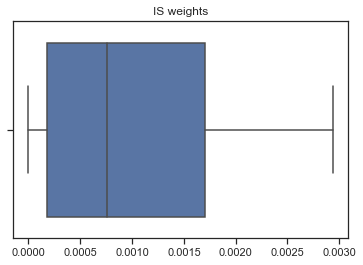

Estimate is [1.02277052 2.0147028 ] with ESS/sample 0.554582021336788


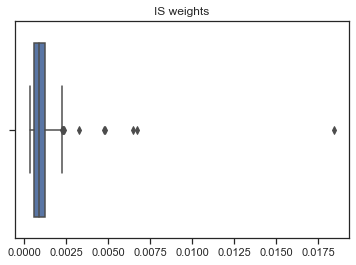

Estimate is [0.94183241 2.09754372] with ESS/sample 0.6149182994749796


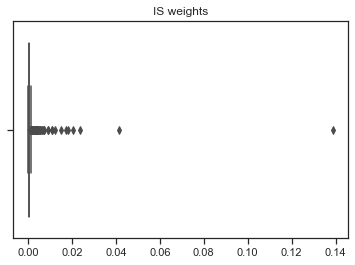

Estimate is [1.00058016 1.90357335] with ESS/sample 0.04084144241777818


In [11]:
sr.run_tests()

# Inferring the linear regression parameters

**Question:** Now we turn to inferring the parameters, how big can you make the ESS by tuning the proposal?

In [42]:
IS = sr.ImportanceSampling(dimension=3, log_target=PM.get_log_target, 
                           num_samples=10000)
IS.find_map(verbose=True)
IS.propose()
res = IS.get_estimate(lambda theta:theta)
print("theta_MEP is", res, "and ESS per sample is", IS.get_ess_per_sample())

MAP is [ 8.67650527 -0.1624689   2.28830579]
Inv. Hessian is [[ 0.66435872 -0.26072705  0.02626826]
 [-0.26072705  0.26596996 -0.03403442]
 [ 0.02626826 -0.03403442  0.21628215]]
theta_MEP is [ 8.81457336 -0.36715731  3.05826308] and ESS per sample is 0.15151137619127317


**Question:** Perform posterior visualisation: Fill in the `get_sample` method if you haven't done so yet, and show a few lines corresponding to approximate posterior samples on the scatter plot of the data. 

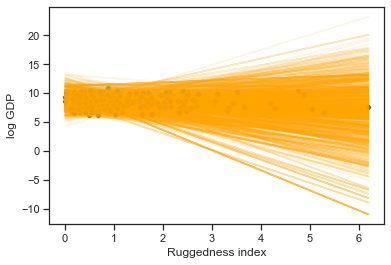

In [43]:
sns.scatterplot(X, y)
plt.ylabel("log GDP")
plt.xlabel("Ruggedness index")
posterior_samples = IS.get_sample(num_resamples=1000)
for theta in posterior_samples:
    plt.plot(X, theta[0] + theta[1]*X, color="orange", alpha=.1)
plt.show()

As a side remark, we can use these posterior samples to approximate the posterior predictive at, say, $x^\star=3$.

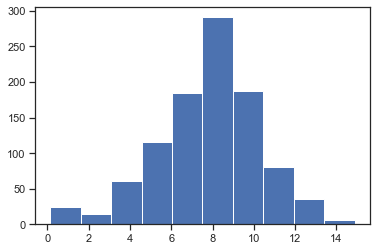

In [44]:
x_star = 3
plt.hist([theta[0] + theta[1]*x_star for theta in posterior_samples])
plt.show()

**Question:** And now, what do we answer our geographer? How sensitive is your decision to your choice of prior?

**Solution:** Again, we compute the posterior mass on $\beta>0$. By definition, this is the integral of $1_{\beta>0}$ with respect to the posterior $\pi(\alpha,\beta,\log\sigma\vert X, \mathbf y)$. We can easily approximate this using our importance sample as follows.

In [46]:
print(IS.get_estimate(lambda theta: theta[1]>0))

[0.36084396]


Again, if $\ell_0=\ell_1$, we need to compare this posterior mass to $1/2$, and this is a close call. Indeed, if we move the prior mean slightly to the left or right of 0, we change the decision. This means that the decision is too prior sensitive, and that the geographer needs either more data or a more constrained model.

**Question:** Now the geographer tells you that she is twice more sensitive to announcing that GDP increases with ruggedness while it doesn't, than the contrary. Does that change your decision? 

**Solution:** In that case, the threshold we need to compare to is $1/3$, and she can thus safely say "no, GDP doesn't increase with ruggedness". We need to change the prior mean by a large amount to change that decision.